In [1]:
!pygmentize code/predictor.py

# This is the file that implements a flask server to do inferences. It's the file that you will modify to
# implement the scoring for your own algorithm.

from __future__ import print_function

import os
import json
import pickle
import sys
import signal
import traceback
import pickle
import torch
import torch_neuron
import transformers
from transformers import BertTokenizer
from transformers import BertModel
import math
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import logging
import numpy as np
import io
import urllib.request



try:
    from StringIO import StringIO ## for Python 2
except ImportError:
    from io import StringIO ## for Python 3

import flask

import pandas as pd

prefix = '/opt/ml/'
model_path = os.path.join(prefix, 'model')

# A singleton for holding the model. This simply loads the model and holds it.
# It has a predict function that does a prediction based on the model and the input data.

class ScoringService(object):
    model =

In [2]:
!cat Dockerfile.sm.neuron-rtd

# Example neuron-rtd dockerfile.

# To build:
#    docker build . -f Dockerfile.neuron-rtd -t neuron-rtd

# Note: the container must start with CAP_SYS_ADMIN + CAP_IPC_LOCK capabilities in order
# to map the memory needed from the Infernetia devices. These capabilities will
# be dropped following initialization.

# i.e. To start the container with required capabilities:
#   docker run --env AWS_NEURON_VISIBLE_DEVICES="0" --cap-add SYS_ADMIN --cap-add IPC_LOCK -v /tmp/neuron_rtd_sock/:/sock neuron-rtd

FROM amazonlinux:2

MAINTAINER Chaitanya Hazarey <chazarey@amazon.com>

RUN echo $'[neuron] \n\
name=Neuron YUM Repository \n\
baseurl=https://yum.repos.neuron.amazonaws.com \n\
enabled=1' > /etc/yum.repos.d/neuron.repo

RUN rpm --import https://yum.repos.neuron.amazonaws.com/GPG-PUB-KEY-AMAZON-AWS-NEURON.PUB

RUN yum install -y wget 
RUN yum install -y aws-neuron-tools
RUN yum install -y aws-neuron-runtime
#RUN yum install -y python
RUN yum install -y tar gzip ca-certificates procps net-

In [3]:
!ls

code  Dockerfile.sm.neuron-rtd	inf1-container.ipynb  inference.py  README.md


In [4]:
%%sh 

# The name of our algorithm
algorithm_name=chazarey-inf1-serving
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR

docker build -t ${algorithm_name} -f Dockerfile.sm.neuron-rtd .
docker tag ${algorithm_name} ${fullname}
docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon   1.02MB
Step 1/20 : FROM amazonlinux:2
 ---> ba2cc467a2bc
Step 2/20 : MAINTAINER Chaitanya Hazarey <chazarey@amazon.com>
 ---> Using cache
 ---> 085017cf994a
Step 3/20 : RUN echo $'[neuron] \nname=Neuron YUM Repository \nbaseurl=https://yum.repos.neuron.amazonaws.com \nenabled=1' > /etc/yum.repos.d/neuron.repo
 ---> Using cache
 ---> 5d059581d13a
Step 4/20 : RUN rpm --import https://yum.repos.neuron.amazonaws.com/GPG-PUB-KEY-AMAZON-AWS-NEURON.PUB
 ---> Using cache
 ---> 46c1279981f7
Step 5/20 : RUN yum install -y wget
 ---> Using cache
 ---> a7522740babe
Step 6/20 : RUN yum install -y aws-neuron-tools
 ---> Using cache
 ---> 93274710b206
Step 7/20 : RUN yum install -y aws-neuron-runtime
 ---> Using cache
 ---> 87e0919b51f8
Step 8/20 : RUN yum install -y tar gzip ca-certificates procps net-tools which vim
 ---> Using cache
 ---> a2c9212f2404
Step 9/20 : RUN amazon-linux-extras install -y nginx1
 ---> Using cache
 ---> 64dce10c009f


WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [5]:
#!pip install 'sagemaker[local]' --upgrade

In [ ]:
%%time

import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import csv_serializer

role = sagemaker.session.get_execution_role()

model_data='s3://inf1-compiled-model/model.tar.gz'

pytorch_model = PyTorchModel(model_data=model_data, 
                             role=role,
                             entry_point='inference.py',
                             image='111652037296.dkr.ecr.us-east-1.amazonaws.com/chazarey-inf1-serving:latest',
                             framework_version='1.5.0',
                             enable_cloudwatch_metrics=True)

predictor = pytorch_model.deploy(instance_type='ml.inf1.xlarge', initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Your model is not compiled. Please compile your model before using Inferentia.


------------!CPU times: user 18.3 s, sys: 4.16 s, total: 22.4 s
Wall time: 6min 50s


In [15]:
import torch
import transformers
from transformers import BertTokenizer
from transformers import BertModel
import math
import numpy as np
import io
from sagemaker.predictor import csv_serializer, json_deserializer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle 

def numpy_bytes_serializer(data):
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

# vnd indicates vendor-specific MIME types, which means they are MIME types that were 
# introduced by corporate bodies rather than e.g. an Internet consortium.


#-predictor.serializer = numpy_bytes_serializer
#-predictor.deserializer = csv_serializer

predictor.content_type = 'application/binary'
predictor.serializer = None
predictor.deserializer = None

sentence1="If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success."
sentence2="The greatest glory in living lies not in never falling, but in rising every time we fall."
sentence3="If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success. If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success. If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success."

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

cos = torch.nn.CosineSimilarity()

encoded_sentence = tokenizer.encode_plus(sentence1, sentence3, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 

try:
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)
    raw_bytes = predictor.predict(pickled_bytes)
except:
    pass
    
    
#print(pickle.loads(raw_bytes))

In [16]:
#type(encoded_sentence_tuple)#
#import pickle 
#msg = pickle.dumps(encoded_sentence_tuple)
#recd = pickle.loads(msg)
#type(recd)
#recd

In [17]:
import random

s_nouns = ["A dude", "My mom", "The king", "Some guy", "A cat with rabies", "A sloth", "Your homie", "This cool guy my gardener met yesterday", "Superman"]
p_nouns = ["These dudes", "Both of my moms", "All the kings of the world", "Some guys", "All of a cattery's cats", "The multitude of sloths living under your bed", "Your homies", "Like, these, like, all these people", "Supermen"]
s_verbs = ["eats", "kicks", "gives", "treats", "meets with", "creates", "hacks", "configures", "spies on", "retards", "meows on", "flees from", "tries to automate", "explodes"]
p_verbs = ["eat", "kick", "give", "treat", "meet with", "create", "hack", "configure", "spy on", "retard", "meow on", "flee from", "try to automate", "explode"]
infinitives = ["to make a pie.", "for no apparent reason.", "because the sky is green.", "for a disease.", "to be able to make toast explode.", "to know more about archeology."]

for i in range(0,10):    
    sentence_random = (random.choice(s_nouns) + ' ' + random.choice(s_verbs) + ' ' + random.choice(s_nouns).lower() or random.choice(p_nouns).lower() + ' ' + random.choice(infinitives))
    encoded_sentence = tokenizer.encode_plus(sentence1, sentence_random, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
    encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)
    
    try:
        raw_bytes = predictor.predict(pickled_bytes)
        embeddings_returned = pickle.loads(raw_bytes)
        s1 = embeddings_returned[1]
        #print(pickle.loads(raw_bytes))
    except:
        pass

    sentence_random = (random.choice(s_nouns) + ' ' + random.choice(s_verbs) + ' ' + random.choice(s_nouns).lower() or random.choice(p_nouns).lower() + ' ' + random.choice(infinitives))
    encoded_sentence = tokenizer.encode_plus(sentence1, sentence_random, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
    encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)
    
    try:
        raw_bytes = predictor.predict(pickled_bytes)
        embeddings_returned = pickle.loads(raw_bytes)
        s2 = embeddings_returned[1]
        #print(pickle.loads(raw_bytes))
    except:
        pass    
    
    cos = torch.nn.CosineSimilarity()    
    s2 = embeddings_returned[1]
    cos_sim = cos(s1,s2)
    cosine_measure = cos_sim[0].item()
    angle_in_radians = math.acos(cosine_measure)
    print(math.degrees(angle_in_radians))

90.6197338238559
26.495729570254856
29.9620998377527
94.29154079669415
38.36727163738609
80.43538673138173
9.00900360836851
18.561097937724725
118.77560497328193
58.631687451258415


In [18]:
import numpy as np 
import datetime
import math
import time
import boto3   
import matplotlib.pyplot as plt


endpoint_name=predictor.endpoint
total_runs=1000

In [19]:
print('Running {} inferences for {}:'.format(total_runs, endpoint_name))

client_times = []
errors_list = []
cw_start = datetime.datetime.utcnow()

errors = 0

for i in range(total_runs):    
    
    client_start = time.time()
    
    sentence_random = (random.choice(s_nouns) + ' ' + random.choice(s_verbs) + ' ' + random.choice(s_nouns).lower() or random.choice(p_nouns).lower() + ' ' + random.choice(infinitives))
    encoded_sentence = tokenizer.encode_plus(sentence1, sentence_random, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
    encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 
    
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)

    try:
        raw_bytes = predictor.predict(pickled_bytes)
        errors_list.append(20)
    except:
        errors += 1
        errors_list.append(30)
        pass
    
    client_end = time.time()
    client_times.append((client_end - client_start)*1000)
    
print('\nErrors - {:.4f} out of {:.4f} total runs | {:.4f}% \n'.format(errors, total_runs, (errors/total_runs)*100))
errors = 0
    
    
cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))

print('Getting Cloudwatch:')
cloudwatch = boto3.client('cloudwatch')
statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
extended=['p50', 'p90', 'p95', 'p100']

# Give 5 minute buffer to end
cw_end += datetime.timedelta(minutes=5)

# Period must be 1, 5, 10, 30, or multiple of 60
# Calculate closest multiple of 60 to the total elapsed time
factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
period = factor * 60
print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
print('Using period of {} seconds\n'.format(period))

cloudwatch_ready = False
# Keep polling CloudWatch metrics until datapoints are available
while not cloudwatch_ready:
  time.sleep(30)
  print('Waiting 30 seconds ...')
  # Must use default units of microseconds
  model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )

  # Should be 1000
  if len(model_latency_metrics['Datapoints']) > 0:
    print('{} latency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
    side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
    side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
    side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
    side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
    side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
    print('Avg | P50 | P90 | P95 | P100')
    print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))

    cloudwatch_ready = True
    
    #embeddings_returned = pickle.loads(raw_bytes)
    #s1 = embeddings_returned[1]
    #print(pickle.loads(raw_bytes))

Running 1000 inferences for chazarey-inf1-serving-2020-08-11-20-52-04-051:

Errors - 0.0000 out of 1000.0000 total runs | 0.0000% 

Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
34.3815 | 33.7483 | 36.4237 | 37.7662

Getting Cloudwatch:
Time elapsed: 334.38501 seconds
Using period of 360 seconds

Waiting 30 seconds ...
1021.0 latency datapoints ready
Avg | P50 | P90 | P95 | P100
23.2284 | 23.3977 | 24.7793 | 26.1717



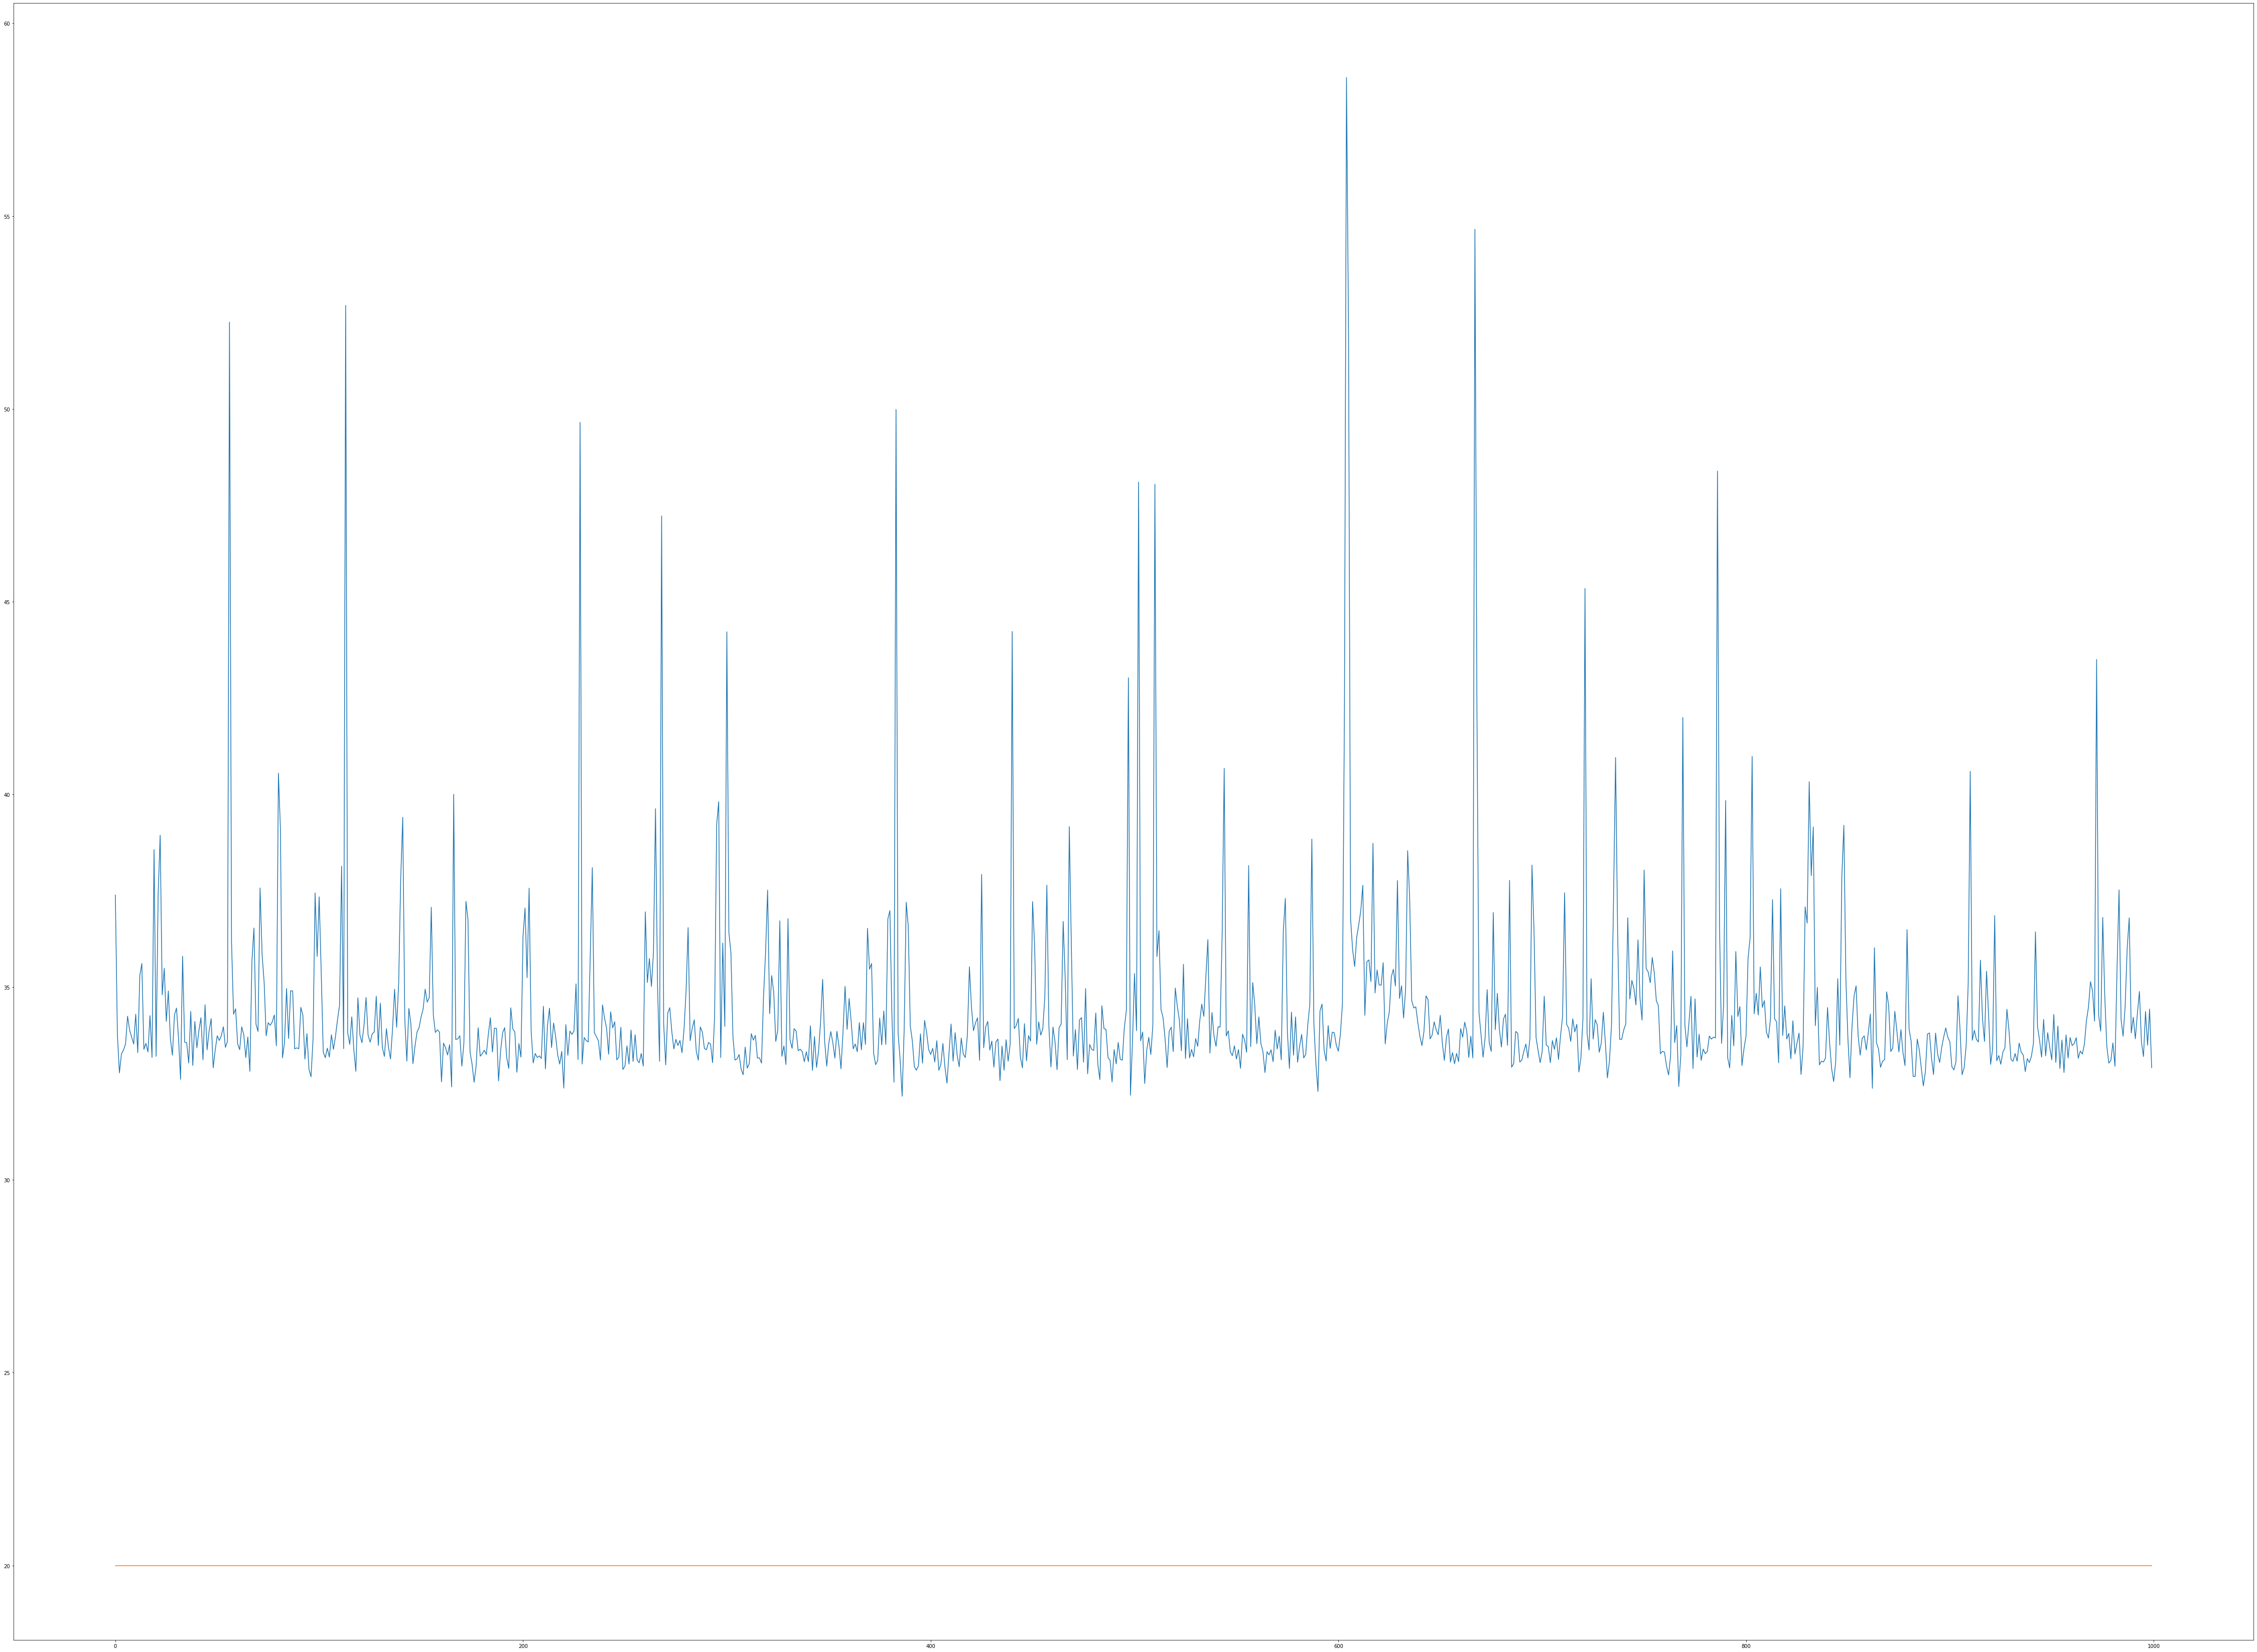

In [20]:
fig = plt.figure(figsize=(80, 60))
ax = fig.add_subplot(111)
ax.plot(client_times)
ax.plot(errors_list)

In [ ]:
client_times

In [ ]:
c = '''client_times = []
cw_start = datetime.datetime.utcnow()

client_start = time.time()

time.sleep(1)

client_end = time.time()

client_times.append((client_end - client_start))

cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))
'''